# Testing Instructions

The pytorch model parameters files for each fold (5 folds each) of each of our backbone models (ResNet50, EfficientNet-B3, Inception-V3) are in the "models" folder, and the test images (184 fundus images) are in the "test_images" folder. Make sure those folders are in the same directory as this file, and that the "test_split.csv" file is also in the same directory.

The models were all trained in DR_Detection.ipynb. This notebook is only for running the models and producing the results (the test dataset for this file is smaller than the one used for our presentation).

Run all the cells in this notebook to load and test all 3 backbone models and display their results.

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [13]:
MODEL_ROOT = "models"
DATA_DIR = "test_images"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

In [3]:
#   ORDINAL RESNET50
class OrdinalResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights="IMAGENET1K_V1")
        base.fc = nn.Identity()
        self.backbone = base
        self.ordinal_layer = nn.Linear(2048, 4)

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.ordinal_layer(feats)
        return logits


#   ORDINAL EFFICIENTNET-B3
class OrdinalEfficientNetB3(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b3(
            weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1
        )
        in_features = base.classifier[1].in_features
        base.classifier = nn.Identity()
        self.backbone = base
        self.ordinal_layer = nn.Linear(in_features, 4)

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.ordinal_layer(feats)
        return logits
        
#   ORDINAL INCEPTION-V3
class OrdinalInceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.inception_v3(weights="IMAGENET1K_V1", aux_logits=True)
        base.aux_logits = False
        base.fc = nn.Identity()
        self.backbone = base
        self.ordinal_layer = nn.Linear(2048, 4)

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.ordinal_layer(feats)
        return logits

In [4]:
class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["id_code"] + ".png"  # APTOS image format
        img_path = os.path.join(self.img_dir, img_name)

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = int(row["diagnosis"])
        return img, label

In [5]:
def ordinal_decode(logits):
    """Convert 4 ordinal logits → single class prediction."""
    probs = torch.sigmoid(logits)          # shape (B,4)
    passed = (probs > 0.5).sum(dim=1)      # count thresholds satisfied
    return passed

In [6]:
def load_all_models(model_root):
    all_models = {}

    for folder in os.listdir(model_root):
        folder_path = os.path.join(model_root, folder)
        if not os.path.isdir(folder_path):
            continue

        print(f"\n=== Found model folder: {folder} ===")
        group_models = {}

        for fname in os.listdir(folder_path):
            if fname.endswith(".pt"):
                model_path = os.path.join(folder_path, fname)
                print(f"  Found model file: {fname}")
                
                # Only store file path — do NOT load the model here
                group_models[fname] = model_path
        
        all_models[folder] = group_models

    return all_models

all_models = load_all_models(MODEL_ROOT)


=== Found model folder: en_models ===
  Found model file: best_en_model_fold_1.pt
  Found model file: best_en_model_fold_2.pt
  Found model file: best_en_model_fold_3.pt
  Found model file: best_en_model_fold_4.pt
  Found model file: best_en_model_fold_5.pt

=== Found model folder: rn_models ===
  Found model file: best_rn_model_fold_1.pt
  Found model file: best_rn_model_fold_2.pt
  Found model file: best_rn_model_fold_3.pt
  Found model file: best_rn_model_fold_4.pt
  Found model file: best_rn_model_fold_5.pt


In [7]:
test_transform_rn = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

eff_b3_weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
test_transform_en = eff_b3_weights.transforms()

test_transform_i = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ResNet-50

Testing best_rn_model_fold_1.pt
Testing best_rn_model_fold_2.pt
Testing best_rn_model_fold_3.pt
Testing best_rn_model_fold_4.pt
Testing best_rn_model_fold_5.pt


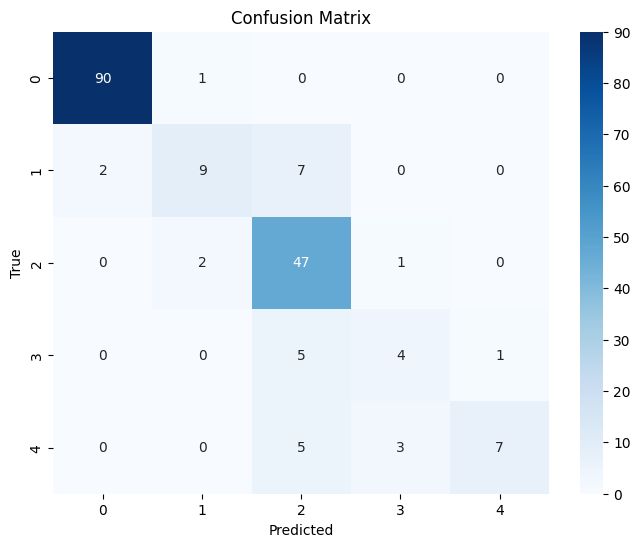

In [8]:
test_dataset = RetinopathyDataset("test_split.csv", DATA_DIR, test_transform_rn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []

for foldModel in all_models["rn_models"]:
    print(f"Testing {foldModel}")

    # Load ordinal model
    model = OrdinalResNet50().to(DEVICE)
    model.load_state_dict(torch.load(all_models["rn_models"][foldModel], map_location=DEVICE))
    model.eval()

    fold_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            logits = model(images)                # shape (B,4)
            preds = ordinal_decode(logits)        # shape (B,)
            fold_preds.append(preds.cpu())
            if "1" in foldModel:
                 all_true.append(labels)

    fold_preds = torch.cat(fold_preds, dim=0)     # shape (N,)
    all_fold_preds.append(fold_preds)

# ---- Ordinal Ensemble: majority vote across folds ----
stacked = torch.stack(all_fold_preds)             # shape (5, N)
ensemble_preds, _ = torch.mode(stacked, dim=0)    # majority vote

# final_preds is a vector of length N with values 0–4
final_preds = ensemble_preds

#confusion matrix
y_true = torch.cat(all_true, dim = 0)

cm = confusion_matrix(y_true, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Test set accuracy: 0.8533
Test set QWK: 0.9267


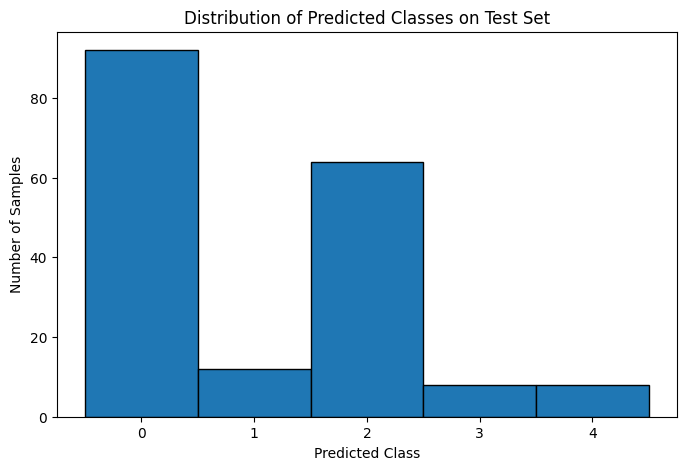

In [9]:
test_csv_path = "test_split.csv"
test_df = pd.read_csv(test_csv_path)
# Accuracy
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

#QWK
y_true = true_labels.numpy() if torch.is_tensor(true_labels) else true_labels
y_pred = final_preds.numpy() if torch.is_tensor(final_preds) else final_preds

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Test set QWK: {qwk:.4f}")

# Distribution plot
plt.figure(figsize=(8,5))
plt.hist(final_preds.numpy(), bins=np.arange(6)-0.5, edgecolor='black')
plt.xticks(range(5))
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()

# EfficientNet-B3

Testing best_en_model_fold_1.pt
Testing best_en_model_fold_2.pt
Testing best_en_model_fold_3.pt
Testing best_en_model_fold_4.pt
Testing best_en_model_fold_5.pt


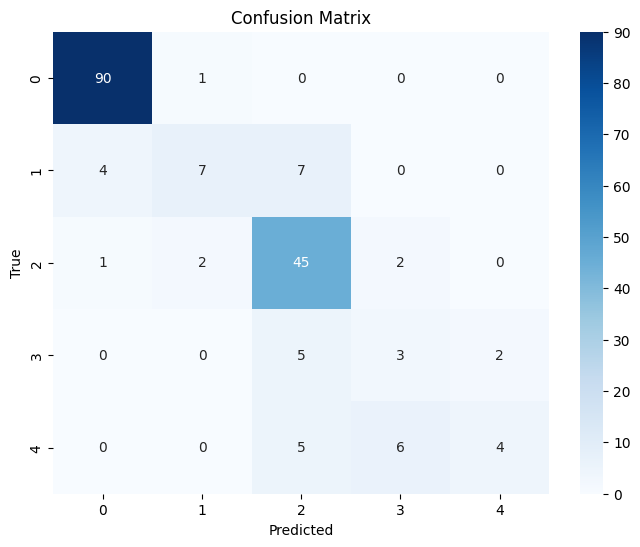

In [10]:
test_dataset = RetinopathyDataset("test_split.csv", DATA_DIR, test_transform_en)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []

for foldModel in all_models["en_models"]:
    print(f"Testing {foldModel}")

    # Load ordinal model
    model = OrdinalEfficientNetB3().to(DEVICE)
    model.load_state_dict(torch.load(all_models["en_models"][foldModel], map_location=DEVICE))
    model.eval()

    fold_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            logits = model(images)                # shape (B,4)
            preds = ordinal_decode(logits)        # shape (B,)
            fold_preds.append(preds.cpu())
            if "1" in foldModel:
                 all_true.append(labels)

    fold_preds = torch.cat(fold_preds, dim=0)     # shape (N,)
    all_fold_preds.append(fold_preds)

# ---- Ordinal Ensemble: majority vote across folds ----
stacked = torch.stack(all_fold_preds)             # shape (5, N)
ensemble_preds, _ = torch.mode(stacked, dim=0)    # majority vote

# final_preds is a vector of length N with values 0–4
final_preds = ensemble_preds

#confusion matrix
y_true = torch.cat(all_true, dim = 0)

cm = confusion_matrix(y_true, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Test set accuracy: 0.8098
Test set QWK: 0.9069


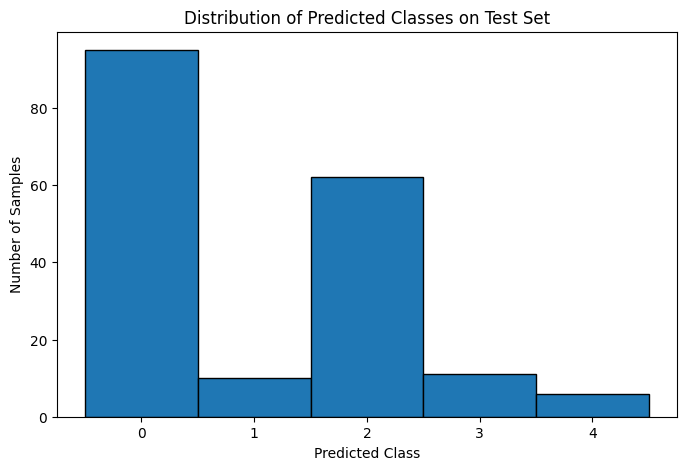

In [11]:
test_csv_path = "test_split.csv"
test_df = pd.read_csv(test_csv_path)
# Accuracy
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

#QWK
y_true = true_labels.numpy() if torch.is_tensor(true_labels) else true_labels
y_pred = final_preds.numpy() if torch.is_tensor(final_preds) else final_preds

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Test set QWK: {qwk:.4f}")

# Distribution plot
plt.figure(figsize=(8,5))
plt.hist(final_preds.numpy(), bins=np.arange(6)-0.5, edgecolor='black')
plt.xticks(range(5))
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()

# Inception-V3

In [12]:
test_dataset = RetinopathyDataset("test_split.csv", DATA_DIR, test_transform_i)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

num_folds = 5
all_fold_preds = []
all_true = []

for foldModel in all_models["i_models"]:
    print(f"Testing {foldModel}")

    # Load ordinal model
    model = OrdinalInceptionV3().to(DEVICE)
    model.load_state_dict(torch.load(all_models["i_models"][foldModel], map_location=DEVICE))
    model.eval()

    fold_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            logits = model(images)                # shape (B,4)
            preds = ordinal_decode(logits)        # shape (B,)
            fold_preds.append(preds.cpu())
            if "1" in foldModel:
                 all_true.append(labels)

    fold_preds = torch.cat(fold_preds, dim=0)     # shape (N,)
    all_fold_preds.append(fold_preds)

# ---- Ordinal Ensemble: majority vote across folds ----
stacked = torch.stack(all_fold_preds)             # shape (5, N)
ensemble_preds, _ = torch.mode(stacked, dim=0)    # majority vote

# final_preds is a vector of length N with values 0–4
final_preds = ensemble_preds

#confusion matrix
y_true = torch.cat(all_true, dim = 0)

cm = confusion_matrix(y_true, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

KeyError: 'i_models'

In [ ]:
test_csv_path = "test_split.csv"
test_df = pd.read_csv(test_csv_path)
# Accuracy
true_labels = torch.tensor(test_df["diagnosis"].values)
accuracy = (final_preds == true_labels).sum().item() / len(true_labels)
print(f"Test set accuracy: {accuracy:.4f}")

#QWK
y_true = true_labels.numpy() if torch.is_tensor(true_labels) else true_labels
y_pred = final_preds.numpy() if torch.is_tensor(final_preds) else final_preds

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Test set QWK: {qwk:.4f}")

# Distribution plot
plt.figure(figsize=(8,5))
plt.hist(final_preds.numpy(), bins=np.arange(6)-0.5, edgecolor='black')
plt.xticks(range(5))
plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()